Importing necessary modules

In [3]:
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram

Defining the Adder-Circuit builder function

In [4]:
def get_qc_for_adder(bits):
    qubits = 2*bits + 2
    carry_out = qubits - 2
    carry_in = qubits - 1
    qc = QuantumCircuit(qubits, bits)
    i = 0
    while(i < carry_out):
        qc.ccx(i, i+1, carry_out)
        qc.cx(i, i+1)
        qc.reset(i)

        if (i+2) == carry_out:
            break
        
        qc.ccx(i+2, carry_out, carry_in)
        qc.cx(carry_out, i+2)
        qc.reset(carry_out)
        qc.cx(carry_in, carry_out)
        qc.reset(carry_in)

        i += 2
    
    qc.measure([(i*2 + 1) for i in range(bits)], range(bits))

    return qc

"set_states" function initializes the qubits according to the inputs

In [5]:
def set_states(qc:QuantumCircuit, num1:str, num2:str) -> QuantumCircuit:
    num1, num2 = num1[::-1], num2[::-1]
    for i in range(len(num1)):
        if num1[i] == '1':
            qc.x(i*2)
    for j in range(len(num2)):
        if num2[j] == '1':
            qc.x(j*2 + 1)
    return qc

Testing with a 3-bit input: |101> and |010>

In [6]:
abc = "101"
a_b_c_ = "010"
bits = max(len(abc), len(a_b_c_))
print(bits)

3


Building Adder-Circuit for 3 bits as specified:

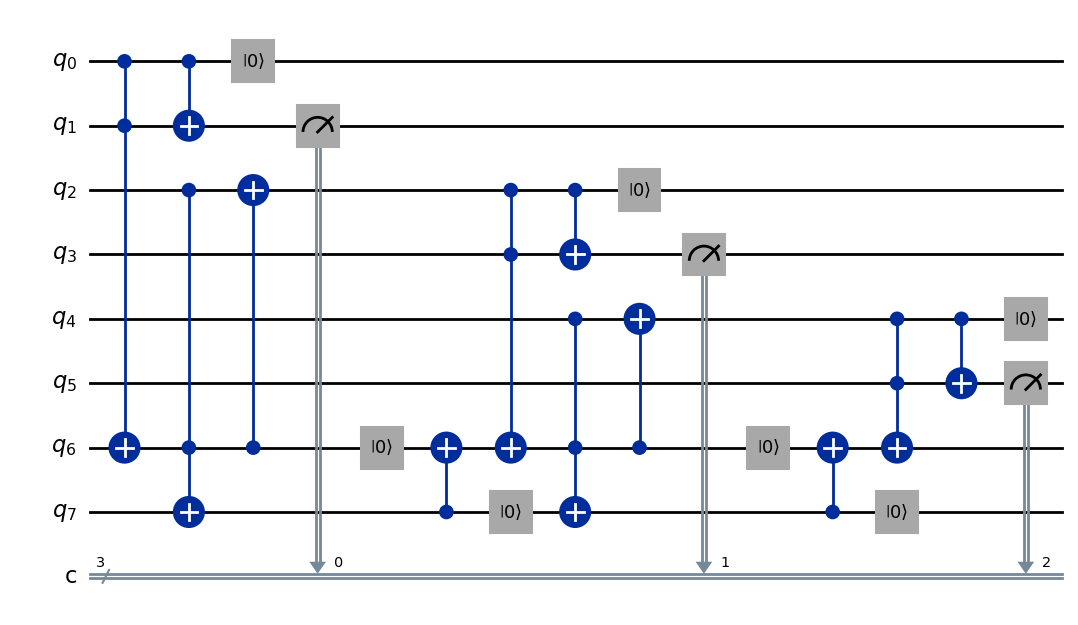

In [7]:
qc = get_qc_for_adder(bits)
display(qc.draw('mpl'))

Circuit after initializing the qubits-states:

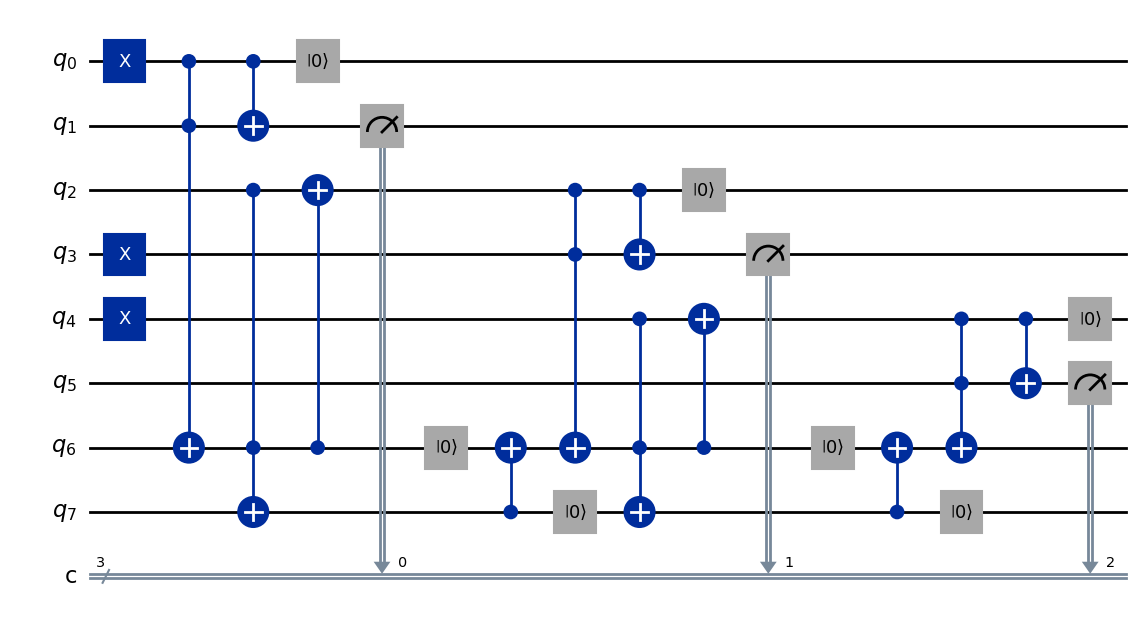

In [8]:
test = QuantumCircuit(2*bits + 2)

test = set_states(test, abc, a_b_c_)
test.compose(qc, inplace=True)

display(test.draw('mpl'))

Running the circuit on AerSimulator:

In [9]:
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=2)
isa_circuit = pm.run(test)
with Session(backend=aer_sim) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([isa_circuit]).result()

Plotting the output:

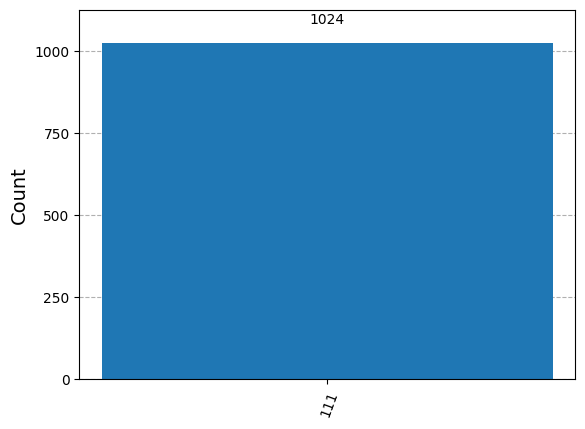

In [10]:
outputs = result[0].data.c
counts = outputs.get_counts()

display(plot_histogram(counts))

Testing with a 4-bit input: |1001> and |0101>

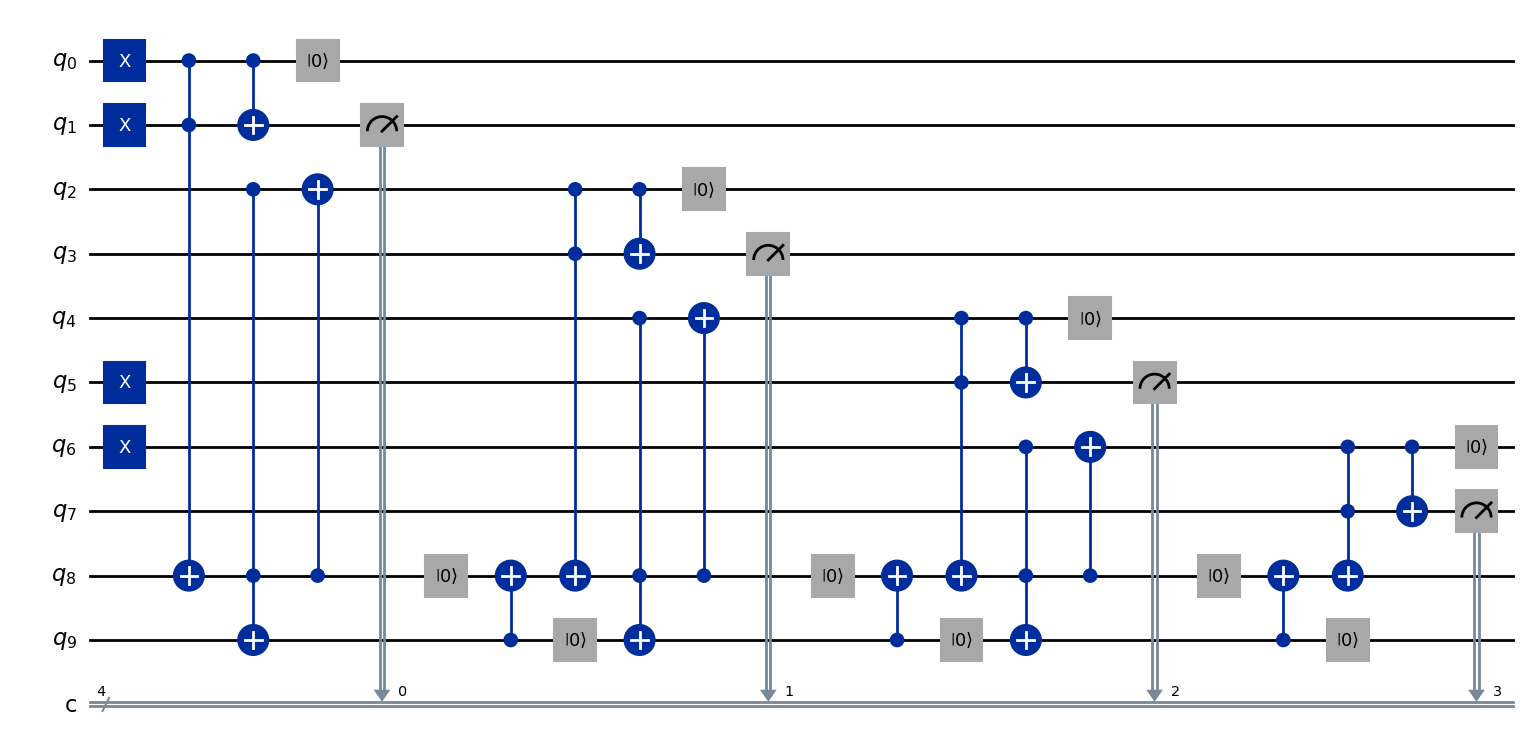

In [11]:
abc = "1001"
a_b_c_ = "0101"
bits = max(len(abc), len(a_b_c_))

qc = get_qc_for_adder(bits)

test = QuantumCircuit(2*bits + 2)

test = set_states(test, abc, a_b_c_)
test.compose(qc, inplace=True)

display(test.draw('mpl'))

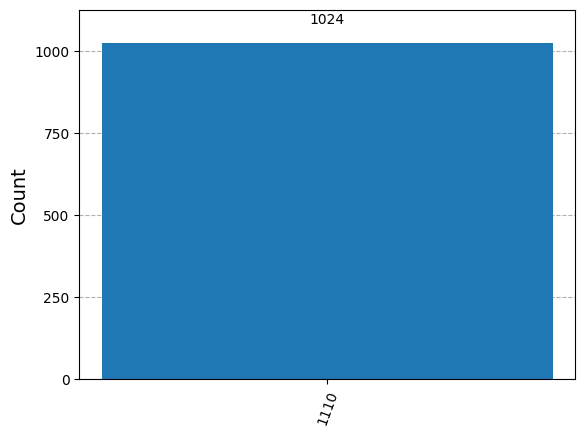

In [12]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=2)
isa_circuit = pm.run(test)
with Session(backend=aer_sim) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([isa_circuit]).result()

outputs = result[0].data.c
counts = outputs.get_counts()

from qiskit.visualization import plot_histogram
display(plot_histogram(counts))

Testing with a 8-bit input: |10010101> and |01001110>

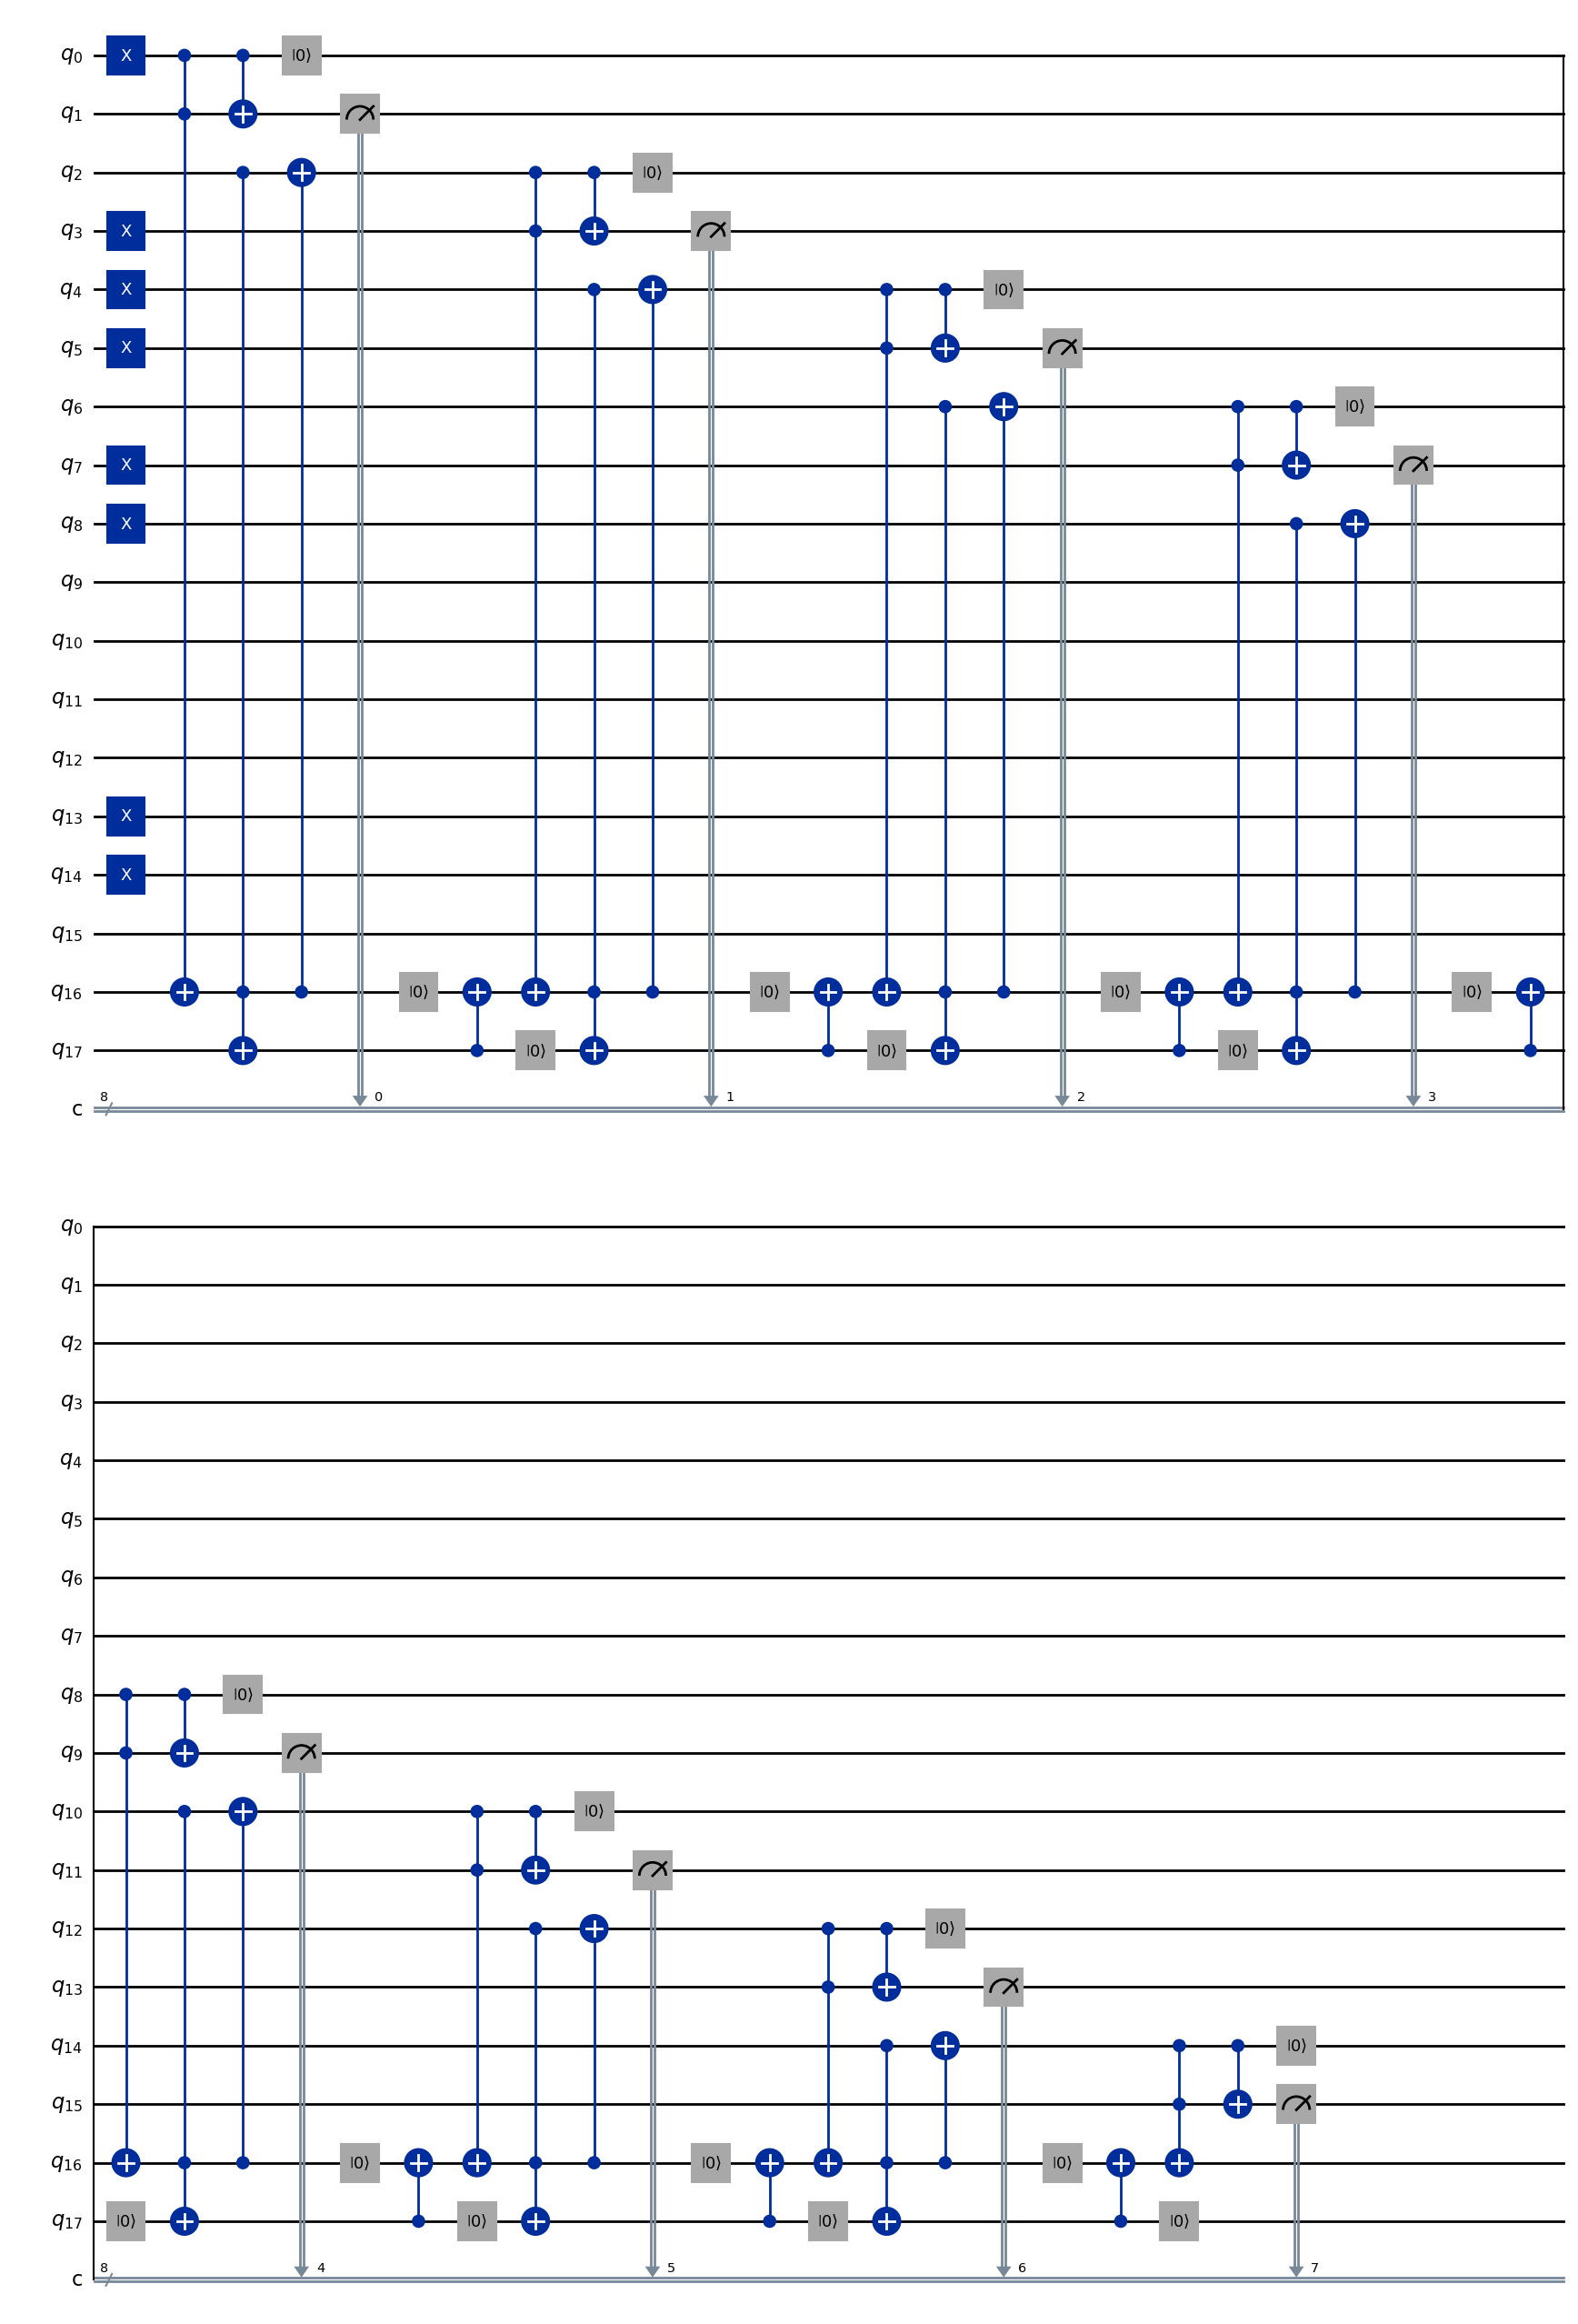

In [13]:
abc = "10010101"
a_b_c_ = "01001110"
bits = max(len(abc), len(a_b_c_))

qc = get_qc_for_adder(bits)

test = QuantumCircuit(2*bits + 2)

test = set_states(test, abc, a_b_c_)
test.compose(qc, inplace=True)

display(test.draw('mpl'))

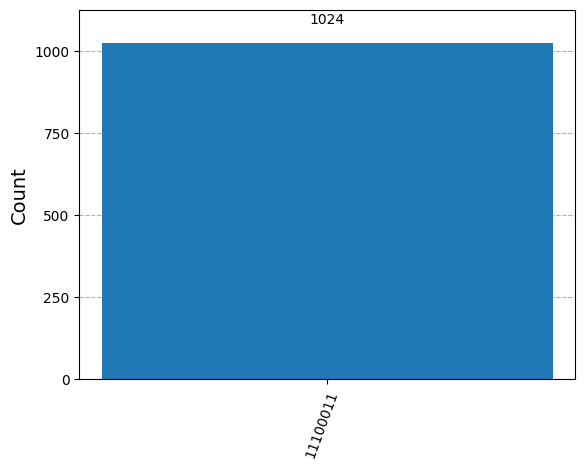

In [14]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=2)
isa_circuit = pm.run(test)
with Session(backend=aer_sim) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([isa_circuit]).result()

outputs = result[0].data.c
counts = outputs.get_counts()

from qiskit.visualization import plot_histogram
display(plot_histogram(counts))

Therefore, the "get_qc_for_adder()" circuit builder is scalable(theoritically infinitely)

Now, running on real Quantum Hardware:

In [15]:
abc = "0111"
a_b_c_ = "0110"
bits = max(len(abc), len(a_b_c_))
print(bits)

4


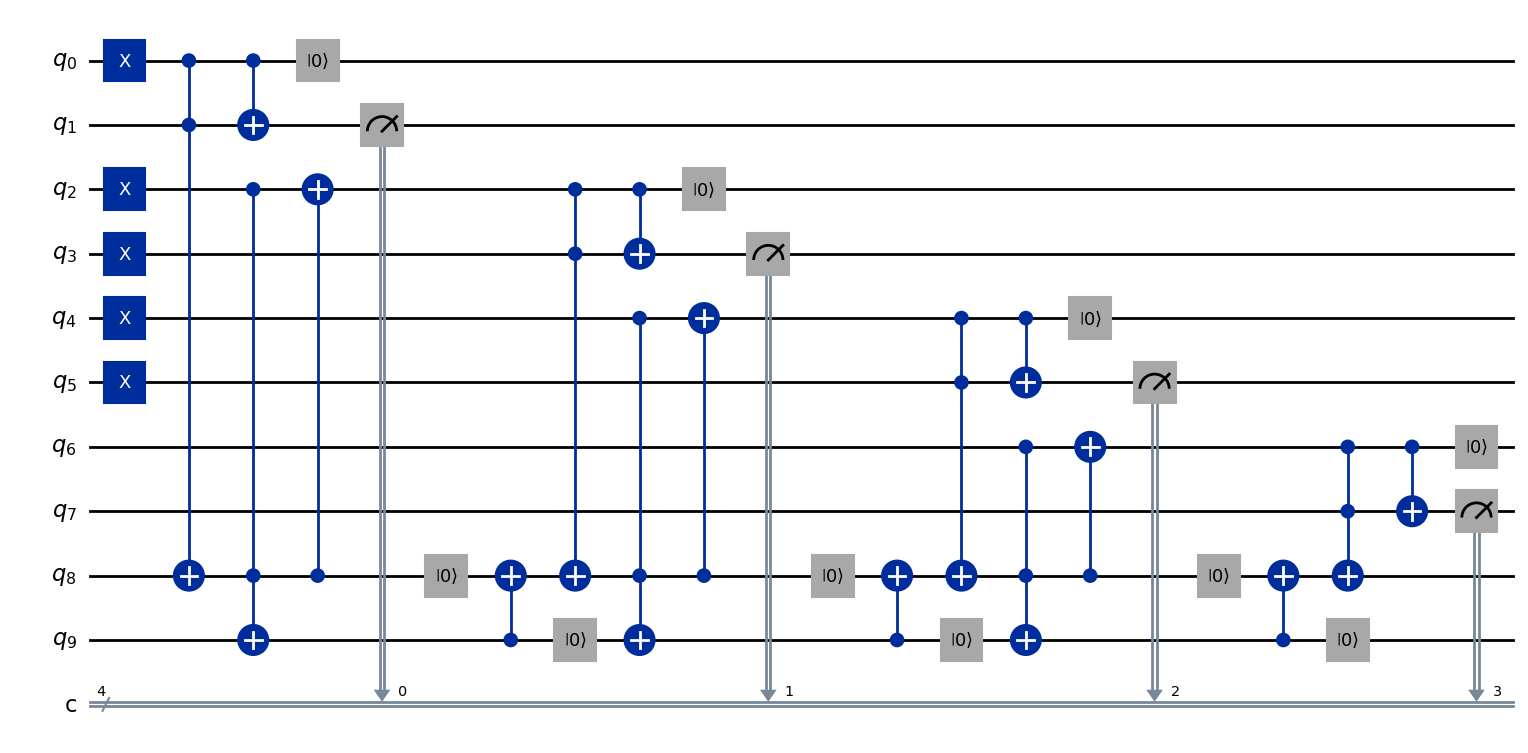

In [16]:
qc = get_qc_for_adder(bits)

test = QuantumCircuit(2*bits + 2)

test = set_states(test, abc, a_b_c_)
test.compose(qc, inplace=True)

display(test.draw('mpl'))

Getting a backend:

In [21]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile

service = QiskitRuntimeService(channel='ibm_quantum', token='<token>')
backend = service.backend('ibm_brisbane')

Transpilation: (2-step transpilation for better error mitigation)

In [22]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, scheduling_method='alap')
isa_circuit = pm.run(test)

transpiled_circuit = transpile(isa_circuit, backend=backend, optimization_level=3, scheduling_method='alap')

Running the circuit with SamplerV2

In [23]:
sampler = Sampler(mode=backend)

sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.dynamical_decoupling.scheduling_method = 'alap'
sampler.options.dynamical_decoupling.extra_slack_distribution = 'middle'

job = sampler.run([transpiled_circuit], shots=20000)

In [26]:
result = job.result()

outputs = result[0].data.c
statistics = outputs.get_counts()
print(statistics)

{'1101': 2762, '1111': 1218, '1001': 1512, '1100': 2283, '0101': 1774, '0010': 589, '0110': 740, '1011': 961, '0000': 950, '1000': 1375, '1110': 992, '0100': 1479, '0001': 1063, '1010': 858, '0011': 612, '0111': 832}


Plotting the results:

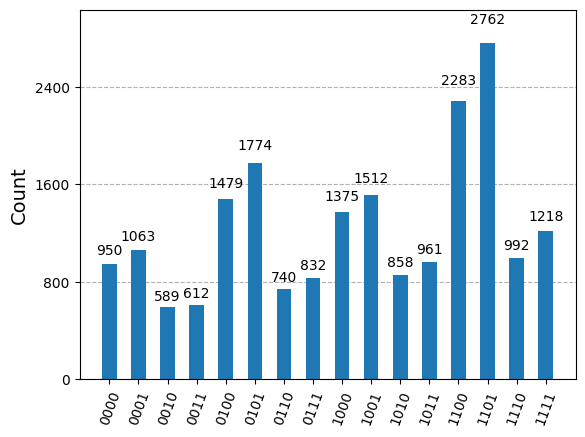

In [27]:
from qiskit.visualization import plot_histogram
display(plot_histogram(statistics))

There is clearly scope for more error mitigation.